In [1]:
!pip install segmentation_models
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import splitfolders

from tqdm import tqdm_notebook, tqdm
from warnings import filterwarnings as fws
fws('ignore')

Segmentation Models: using `keras` framework.


In [3]:
splitfolders.ratio("/kaggle/input/01-final-leaf-segmentation/LEAF_SEGMENTATION", 
                   output="output",
                   seed=143,
                   ratio=(.9, .0, .1))

Copying files: 2121 files [00:05, 357.64 files/s]


In [4]:
train_images = []

for directory_path in glob.glob("/kaggle/working/output/train/image"):
    img_path = glob.glob(os.path.join(directory_path, "*.jpg"))
    img_path.sort()
    for i in tqdm_notebook(img_path):
        img = cv2.imread(i)
        train_images.append(img)
train_images = np.array(train_images)

  0%|          | 0/735 [00:00<?, ?it/s]

In [5]:
# masks are scaled from 0 to 255
train_masks = [] 

for directory_path in glob.glob("/kaggle/working/output/train/mask"):
    msk_path = glob.glob(os.path.join(directory_path, "*.png"))
    msk_path.sort()
    for i in tqdm_notebook(msk_path):
        mask = cv2.imread(i).astype(bool)
        mask = np.where(mask==True, 255, 0).astype('uint8')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        train_masks.append(mask)
        
train_masks = np.array(train_masks)

  0%|          | 0/735 [00:00<?, ?it/s]

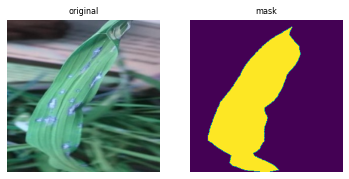

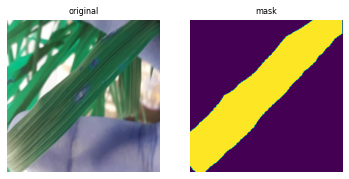

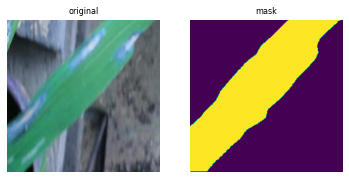

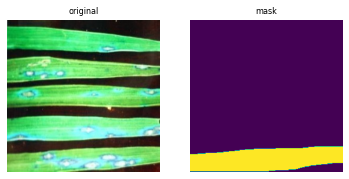

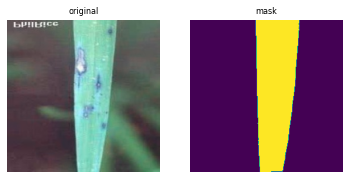

In [6]:
for idx in range(5):
    fig, axs = plt.subplots(nrows=1, ncols=2)

    axs[0].imshow(train_images[idx])
    axs[0].set_title('original', fontsize=8)
    axs[1].imshow(train_masks[idx])
    axs[1].set_title('mask', fontsize=8)

    for i in range(2):
        axs[i].axis('off')

    plt.show()

In [7]:
def normalize(image_array):
    return cv2.normalize(image_array, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

X = np.array([normalize(i).astype('float32') for i in train_images])
Y = np.array([normalize(i).astype('uint8') for i in train_masks])

In [8]:
print(X.shape)
print(Y.shape)

print(X.min())
print(X.max())

(735, 256, 256, 3)
(735, 256, 256)
-1.44355e-08
1.0


In [10]:
from sklearn.model_selection import train_test_split
from segmentation_models import metrics

sm.set_framework('tf.keras')
sm.framework()

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# preprocess input
BACKBONE = 'resnet34'

preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy', metrics.FScore()])

print(model.summary())

2023-01-27 13:19:27.693461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 13:19:27.694710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 13:19:27.695692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 13:19:27.696836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 13:19:27.697965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

85532672/85521592 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [11]:
from keras.callbacks import ModelCheckpoint
filepath = "normalized_adagrad-v1.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_f1-score', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train, y_train,
                    batch_size=16, 
                    epochs=100,
                    verbose=1,
                    validation_data=(x_val, y_val), 
                    callbacks=[checkpoint])

2023-01-27 13:19:55.649453: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-27 13:20:01.005106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 19s 224ms/step - loss: 0.7798 - accuracy: 0.5190 - f1-score: 0.3635 - val_loss: 0.7486 - val_accuracy: 0.3359 - val_f1-score: 0.3934

Epoch 00001: val_f1-score improved from -inf to 0.39339, saving model to normalized_adagrad-v1.h5
Epoch 2/100
33/33 [==============================] - 5s 154ms/step - loss: 0.6598 - accuracy: 0.6283 - f1-score: 0.3855 - val_loss: 0.6928 - val_accuracy: 0.5239 - val_f1-score: 0.3838

Epoch 00002: val_f1-score did not improve from 0.39339
Epoch 3/100
33/33 [==============================] - 5s 155ms/step - loss: 0.5914 - accuracy: 0.6927 - f1-score: 0.4150 - val_loss: 0.6476 - val_accuracy: 0.6397 - val_f1-score: 0.3697

Epoch 00003: val_f1-score did not improve from 0.39339
Epoch 4/100
33/33 [==============================] - 5s 154ms/step - loss: 0.5417 - accuracy: 0.7373 - f1-score: 0.4346 - val_loss: 0.6129 - val_accuracy: 0.6865 - val_f1-score: 0.3532

Epoch 00004: val_f1-score did not improve from 0.39339
Epoc

In [12]:
import pandas as pd

results_df = pd.DataFrame(history.history)
results_df.to_csv('86_leaf_segmentor_adagrad.csv', index=False)
results_df

,loss,accuracy,f1-score,val_loss,val_accuracy,val_f1-score
0,0.779839,0.518992,0.363547,0.748593,0.335918,0.393386
1,0.659779,0.628302,0.385450,0.692800,0.523857,0.383818
2,0.591441,0.692684,0.415024,0.647640,0.639723,0.369700
3,0.541717,0.737347,0.434617,0.612878,0.686498,0.353223
4,0.498717,0.772742,0.464849,0.597651,0.705330,0.333593
...,...,...,...,...,...,...
95,0.103820,0.962537,0.871664,0.144266,0.946385,0.861555
96,0.103871,0.962779,0.864460,0.144133,0.946441,0.861944
97,0.102201,0.963631,0.864817,0.143169,0.946832,0.863372
98,0.093904,0.966626,0.881246,0.141967,0.947315,0.864030


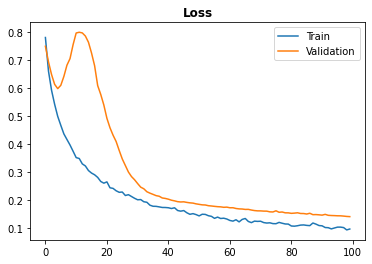

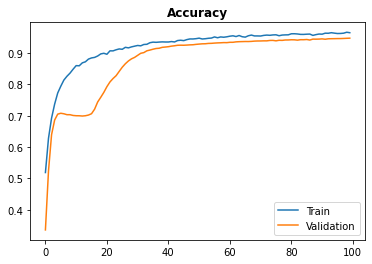

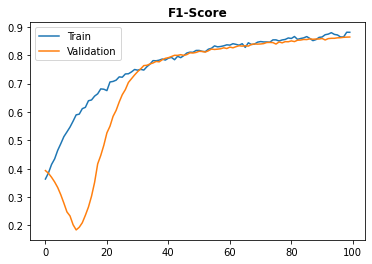

In [13]:
plt.plot(results_df['loss'], label='Train')
plt.plot(results_df['val_loss'], label='Validation')
plt.title('Loss', fontweight='bold')
plt.legend()
plt.show()

plt.plot(results_df['accuracy'], label='Train')
plt.plot(results_df['val_accuracy'], label='Validation')
plt.title('Accuracy', fontweight='bold')
plt.legend()
plt.show()

plt.plot(results_df['f1-score'], label='Train')
plt.plot(results_df['val_f1-score'], label='Validation')
plt.title('F1-Score', fontweight='bold')
plt.legend()
plt.show()

In [14]:
from tensorflow import keras
saved_model = keras.models.load_model('/kaggle/working/normalized_adagrad-v1.h5', compile=False)

In [15]:
test_images = []

for directory_path in glob.glob("/kaggle/working/output/test/image"):
    img_path = glob.glob(os.path.join(directory_path, "*.jpg"))
    img_path.sort()
    for i in tqdm_notebook(img_path):
        img = cv2.imread(i)
        test_images.append(img)
test_images = np.array(test_images)


test_masks = [] 

for directory_path in glob.glob("/kaggle/working/output/test/mask"):
    msk_path = glob.glob(os.path.join(directory_path, "*.png"))
    msk_path.sort()
    for i in tqdm_notebook(msk_path):
        mask = cv2.imread(i).astype(bool)
        mask = np.where(mask==True, 255, 0).astype('uint8')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        test_masks.append(mask)
        
test_masks = np.array(test_masks)

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

In [16]:
test_images = np.array([normalize(i) for i in test_images])
test_masks = np.array([(i/255).astype('uint8') for i in test_masks])

In [17]:
print(test_images.shape)
print(test_masks.shape)

(82, 256, 256, 3)
(82, 256, 256)


In [18]:
def predict(image, threshold=0.7):
#     step1 = preprocess(image)
    step2 = np.expand_dims(image, axis=0)
    
    prediction = saved_model.predict(step2, verbose='silent')
    pred_image = np.squeeze(prediction > threshold)
    return pred_image.astype('uint8')

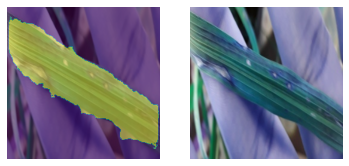

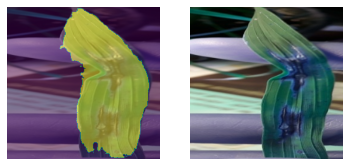

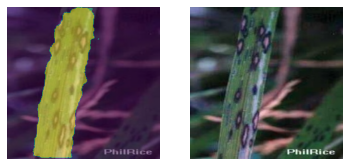

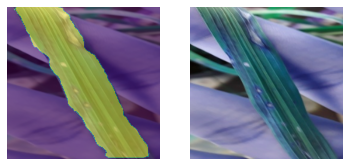

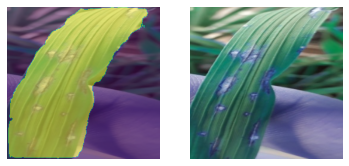

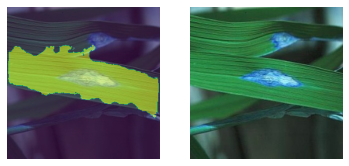

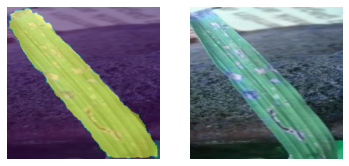

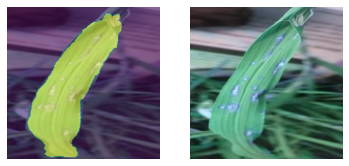

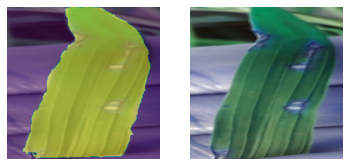

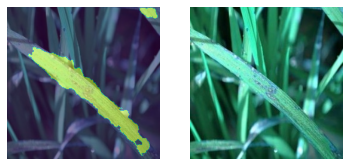

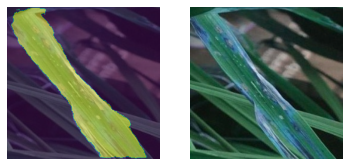

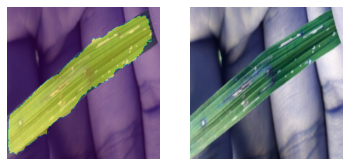

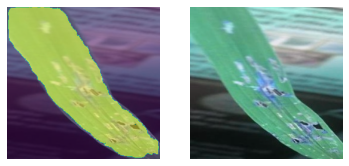

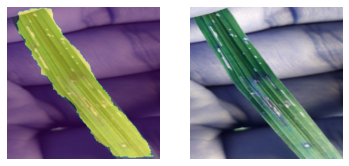

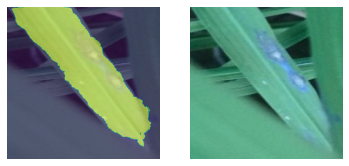

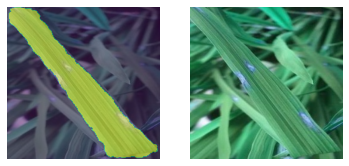

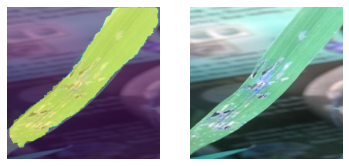

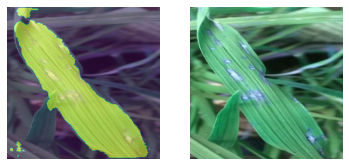

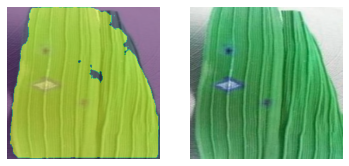

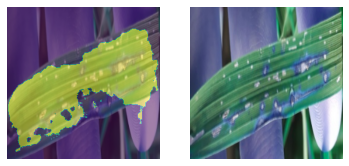

In [19]:
counter = 0
for i in test_images:
    
    pred_image = predict(i)
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(i)
    ax[0].imshow(pred_image, alpha=0.5)
    ax[0].axis('off')
    
    ax[1].imshow(i)
    ax[1].axis('off')
        
    plt.show()
    
    counter += 1
    if counter == 20:
        break

In [21]:
y_pred = []
for i in tqdm_notebook(test_images):
    pred_mask = predict(i)
    y_pred.append(pred_mask)
    
y_pred = np.array(y_pred)

  0%|          | 0/82 [00:00<?, ?it/s]

In [22]:
from sklearn.metrics import f1_score, jaccard_score

y_pred_reshaped = y_pred.reshape(82, 256*256)
y_test_reshaped = test_masks.reshape(82, 256*256)

f1 = f1_score(y_pred_reshaped, y_test_reshaped, average='weighted')
print(f'Mean Dice Coefficient: {f1}')

Mean Dice Coefficient: 0.9131362734326516


In [23]:
iou = jaccard_score(y_pred_reshaped, y_test_reshaped, average='weighted')
print(f'Mean Jaccard Score: {iou}')

Mean Jaccard Score: 0.8455098816815125
